# AI Augmented Data

This notebook illustrates how to interact with the Gemini LLM API to automate label identification using predefined tasks.

- Learn how to set up and interact with an LLM API.
- Learn how to make functions to automate taks.
- Learn to extract attributes from account descriptions.

# Set up your API key

To use the Gemini API, you'll need an API key. If you don't already have one, create a key in Google AI Studio.

<a class="button" href="https://aistudio.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `GOOGLE_API_KEY`. Then pass the key to the SDK:

In [5]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY="COLLEZ_VOTRE_CLE_ICI"
genai.configure(api_key=GOOGLE_API_KEY)

## Initialize the Generative Model

Before you can make any API calls, you need to initialize the Generative Model.

In [6]:
# Define model version & initialize the model
VERSION = "gemini-1.5-flash"
model = genai.GenerativeModel(VERSION)


# Interacting with LLMs

## Generate text

In [17]:
response = model.generate_content("Can you tell me a sci-fi tale in less than 5 sentences?")
print(response.text)

A lone astronaut, stranded on a barren moon, received a faint signal - a message from Earth, but not from humans. It was a plea for help, sent by a dying civilization from a distant galaxy, their last hope riding on the shoulders of a single, lost traveler. 



### Hack Time

In [18]:
# Create an object containing your request and then execute your query.
task = ""
response = model.generate_content(task)
print(response.text)


TypeError: contents must not be empty

# Functions & Automation

In [19]:
# Try to make a function and play with it!


## Functions to generate tasks

In [20]:
def make_task(task_text):
    return f"""
        You are an unbiased US politics expert.
        You will be provided with a Twitter account name and description.
        Your task is to classify the account into one of the following numbered categories:
        {task_text}
        For each of these categories, I have provided a short description to help you with your choice.
        Your output consists only of the number of the selected category, that is the number before the description provided.
    """

### Hack Time

In [21]:
# Test the newly created function


## Create a task dictionary

In [22]:
tasks = {
    "ideology": make_task(
        """
        1. Left wing accounts are those that express political views and opinions or include content that focuses on issues of income equality, environmental protection, social justice, open borders, progressive policies to promote minority representation;
        2. Centre accounts are those that express political views that mix or combine left and right opinion and content such that one opinion or type of content does not dominate;
        3. Right wing accounts are those that express political views and opinions or include content that focuses on issues of economic liberalism, less state intervention in citizens lives, lower taxes, controlling borders and immigration);
        4. Non-partisan accounts are those that typically do not express political views or contain any political content;
        """
    ),
    "age": make_task(
        """
        1. 18-24 Early adulthood, references to college, social media trends, youth culture.
        2. 25-34: Early career stage, potential references to career growth, early family life, pop culture.
        3. 35-44: Mid-career, family-oriented topics, more established professional references.
        4. 45-54: Experienced career stage, references to leadership roles, mature pop culture.
        5. 55-64: Pre-retirement stage, discussions about retirement, long-term career, older family dynamics.
        6. 65+: Retirement, senior living, nostalgia, grandparenting.
        0. Unclassifiable/Insufficient Information.
        """
    ),
    "gender": make_task(
        """
        1. Male: Masculine language, traditional male-dominated interests or references.
        2. Female: Feminine language, topics or references more common among women.
        3. Non-binary/Genderqueer: Non-gendered language, a mix of traditionally male and female references.
        0. Unclassifiable/Insufficient Information.
        """
    ),
    "education": make_task(
        """
        1. High School or Lower: Basic language use, common knowledge, fewer technical terms.
        2. Some College/Technical School: Intermediate language, some industry-specific terms or references.
        3. Undergraduate Degree: Advanced language, references to undergraduate-level education.
        4. Graduate Degree (Master’s, PhD): Complex language, use of specialized terminology, advanced concepts.
        5. Professional Certifications: Industry-specific jargon, focus on certification-related content.
        0. Unclassifiable/Insufficient Information.
        """
    ),
}

In [23]:
# Test it!


# Putting it all together.

## Get some Data

In [24]:
import pandas as pd

DATA_PATH = "https://raw.githubusercontent.com/mickaeltemporao/workshop-ai-augmented-data/main/data/raw/us_pols_20.csv"
df = pd.read_csv(DATA_PATH)
cols = ['username', 'description']
df[cols].head()

,username,description
0,votetimmons,Fighting for #SC04 in Congress. Captain in the...
1,RepHartzler,"The archived tweets of Vicky Hartzler, fmr Rep..."
2,DrJillStein,Medical doctor. Presidential candidate. People...
3,madeleine,Author of the NYT bestseller Hell and Other De...
4,WydenPress,Official account of U.S. Senator @RonWyden 's ...


*REMEMBER*:
- We need to provide the LLM with a name and an account description.
We can make a simple function to do this.

In [25]:
def make_content(obs):
    output = f"""
Account name: {obs['username']}
Account description: {obs['description']}
"""
    return output

## Hack Time

In [26]:
# Test your newly created function


## Raising the Stakes

In [27]:
model=genai.GenerativeModel(
    model_name=VERSION,
    system_instruction=tasks['age']
)

response = model.generate_content(
    make_content(df.iloc[0]),
    generation_config=genai.types.GenerationConfig(
        candidate_count=1,
        stop_sequences=['x'],
        max_output_tokens=10,
        temperature=0.7,
    )
)
print(response.text)


4 



# We can automate this for more users & tasks!

In [28]:
def run_task(task, content):
    model=genai.GenerativeModel(
      model_name=VERSION,
      system_instruction=task
    )
    response = model.generate_content(
        content,
        generation_config=genai.types.GenerationConfig(
            candidate_count=1,
            stop_sequences=['x'],
            max_output_tokens=10,
            temperature=0.7,
        )
    )
    output = response.text
    return output


In [31]:
def main():
    for task in tasks:
        print(f"Starting {task}")
        newcol = f'task_{task}'

        if newcol not in df.columns:
            df[newcol] = "NONE"

        for i, j in df.iterrows():
            if df.loc[j.name, newcol] != "NONE":
                continue
            print(f"Running task for {j.name}")
            task_output = run_task(
                tasks[task],
                make_content(j)
            )
            df.loc[j.name, newcol] = task_output


In [32]:
# Let's try this!
main()

Starting ideology
Running task for 0
Running task for 1
Running task for 2
Running task for 3
Running task for 4
Running task for 5


KeyboardInterrupt: 

### Hack Time

In [35]:
# Take a look at the newly created data!
df

,name,username,sex,age,party,description,task_ideology
0,William Timmons,votetimmons,male,40.0,Republican Party,Fighting for #SC04 in Congress. Captain in the...,3 \n
1,Vicky Hartzler,RepHartzler,female,64.0,Republican Party,"The archived tweets of Vicky Hartzler, fmr Rep...",3 \n
2,Jill Stein,DrJillStein,female,74.0,Green Party of the United States,Medical doctor. Presidential candidate. People...,1 \n
3,Madeleine Albright,madeleine,female,87.0,Democratic Party,Author of the NYT bestseller Hell and Other De...,2 \n
4,Ron Wyden,WydenPress,male,75.0,Democratic Party,Official account of U.S. Senator @RonWyden 's ...,1 \n
5,Mike Pence,mike_pence,male,65.0,Republican Party,"Christian, Conservative, Republican- In That O...",NONE
6,Tim Burchett,timburchett,male,60.0,Republican Party,Married to Kelly. Father to Isabel. Congressma...,NONE
7,Dianne Feinstein,SenFeinstein,female,91.0,Democratic Party,United States Senator from California. On Face...,NONE
8,Aftab Pureval,aftabpureval,male,42.0,Democratic Party,70th Mayor of Cincinnati. Ohio born and raised...,NONE
9,Vanessa Gibson,Vanessalgibson,female,45.0,Democratic Party,"The 14th Bronx Borough President, Former Counc...",NONE


In [37]:
# Focus only on the newly created columns
cols = ['task_ideology']
df[cols]


,task_ideology
0,3 \n
1,3 \n
2,1 \n
3,2 \n
4,1 \n
5,NONE
6,NONE
7,NONE
8,NONE
9,NONE


In [65]:
# What is this?
# DATA_PATH = "https://raw.githubusercontent.com/mickaeltemporao/workshop-ai-augmented-data/main/data/tmp/us_pols_20.csv"
# df = pd.read_csv(DATA_PATH)

In [66]:
df.info

<bound method DataFrame.info of                   name         username     sex   age  \
0      William Timmons      votetimmons    male  40.0   
1       Vicky Hartzler      RepHartzler  female  64.0   
2           Jill Stein      DrJillStein  female  74.0   
3   Madeleine Albright        madeleine  female  87.0   
4            Ron Wyden       WydenPress    male  75.0   
5           Mike Pence       mike_pence    male  65.0   
6         Tim Burchett      timburchett    male  60.0   
7     Dianne Feinstein     SenFeinstein  female  91.0   
8        Aftab Pureval     aftabpureval    male  42.0   
9       Vanessa Gibson   Vanessalgibson  female  45.0   
10   Guy Reschenthaler    reschenthaler    male  41.0   
11      Michelle Giuda    michellegiuda  female  39.0   
12      Heather Wilson  HeatherAnWilson  female  64.0   
13         Jared Polis       JaredPolis    male  49.0   
14           Bob Latta         BobLatta    male  68.0   

                               party  \
0                   Republican Party   
1                   Republican Party   
2   Green Party of the United States   
3                   Democratic Party   
4                   Democratic Party   
5                   Republican Party   
6                   Republican Party   
7                   Democratic Party   
8                   Democratic Party   
9                   Democratic Party   
10                  Republican Party   
11       California Republican Party   
12                  Republican Party   
13                  Democratic Party   
14                  Republican Party   

                                          description  task_ideology  \
0   Fighting for #SC04 in Congress. Captain in the...              3   
1   The archived tweets of Vicky Hartzler, fmr Rep...              3   
2   Medical doctor. Presidential candidate. People...              1   
3   Author of the NYT bestseller Hell and Other De...              2   
4   Official account of U.S. Senator @RonWyden 's ...              1   
5   Christian, Conservative, Republican- In That O...              3   
6   Married to Kelly. Father to Isabel. Congressma...              3   
7   United States Senator from California. On Face...              3   
8   70th Mayor of Cincinnati. Ohio born and raised...              4   
9   The 14th Bronx Borough President, Former Counc...              1   
10  U.S. Representative for PA-14. House Republica...              3   
11  CEO of the Krach Institute for @TechDiplomacy ...              4   
12  @UTEP President. @NSF Board. Former @usairforc...              4   
13  Platinum recording artist, father, entrepreneu...              3   
14  Representing #OH5 in Congress. Deputy Whip. Me...              3   

    task_age  task_gender  task_education  
0          4            1               2  
1          0            2               2  
2          5            2               3  
3          4            2               4  
4          0            0               2  
5          4            1               2  
6          4            1               2  
7          4            2               4  
8          3            1               0  
9          3            2               2  
10         4            1               4  
11         3            2               4  
12         5            2               4  
13         4            1               3  
14         4            1               2  >

In [67]:
df[cols] = df[cols].apply(pd.to_numeric)
#.astype('category')


# Making Plots?

Using Grammar of Graphics in Python: [plotnine](https://plotnine.org/)

In [87]:
# Sounds familiar?
from plotnine import ggplot, aes, geom_bar, theme_538

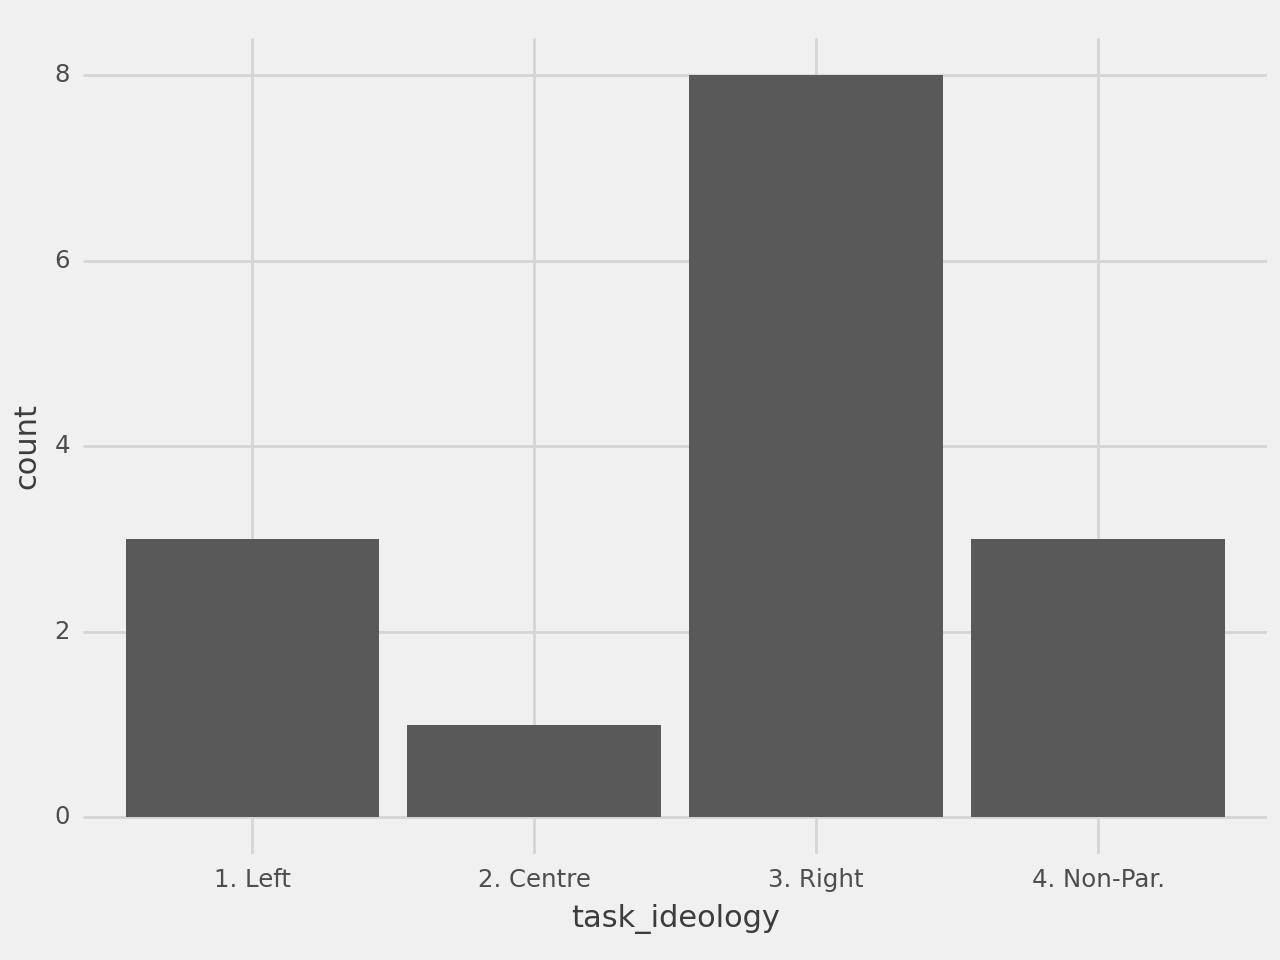

<Figure Size: (640 x 480)>

In [86]:
# Let's make a bar plot
(
    ggplot(df)
    + geom_bar(aes(x="task_ideology"))
    + theme_538()
)


In [84]:
# Define your Labels
age_labels = { 1: "18-24", 2: "25-34", 3: "35-44", 4: "45-54", 5: "55-64", 6: "65+", }
gender_labels = { 1: "Male", 2: "Female", 3: "Other", }
education_labels = { 1: "1. High School or Less", 2: "2. Some College", 3: "4. Undergrad Degree", 4: "5. Grad Degree", 5: "3. Certifications", }
ideology_labels = {1: "1. Left", 2: "2. Centre", 3: "3. Right", 4: "4. Non-Par."}


In [85]:
# And Replace
df['task_age'] = df['task_age'].replace(age_labels)
df['task_gender'] = df['task_gender'].replace(gender_labels)
df['task_education'] = df['task_education'].replace(education_labels)
df['task_ideology'] = df['task_ideology'].replace(ideology_labels)
df[cols]


,task_ideology
0,3. Right
1,3. Right
2,1. Left
3,2. Centre
4,1. Left
5,3. Right
6,3. Right
7,3. Right
8,4. Non-Par.
9,1. Left


In [80]:
# Let's make a bar plot
(
    ggplot(df)
    + geom_bar(aes(x="task_ideology"))
    + theme_538()
)


AttributeError: module 'mizani.colors.brewer.sequential' has no attribute 'Set1'

### Hack Time

In [88]:
# How did age perform?
df['age']

,age
0,40.0
1,64.0
2,74.0
3,87.0
4,75.0
5,65.0
6,60.0
7,91.0
8,42.0
9,45.0


In [ ]:
# Recoding Age into categories